# Data Preprocessing

In [112]:
import os
import statistics
import torch
import math
from Bio import SeqIO
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pandas as pd
import re
from functools import reduce
import numpy as np
import seaborn as sn


In [245]:
fasta_file = 'trna/lotta_trna.fa'

In [246]:
n = 0 
for rec in SeqIO.parse(fasta_file, "fasta"):
    n+= 1

In [247]:
n #the number of sequences in our file

276918

In [269]:
trnas = []
fasta_file = 'trna/trna.fa'
for record in SeqIO.parse(fasta_file, "fasta"):
        trnas.append(str(record.seq).upper())

random.seed(42)
random.shuffle(trnas)
trnas = trnas[:200000]
trnas= [re.sub(r'.*[^GCTAN].*', '', s) for s in trnas] #replaces strings w/ non bases with empty string


In [270]:
#K = [s for s in trnas if 'NNNNNNN' in s]
#trnas = [i for i in trnas if i not in K] #remove sequences with long sequences of NNNNNNN

while('' in trnas):  #remove empty sequences
    trnas.remove('')


In [271]:
len(trnas)

27712

In [272]:
trnas = [s for s in trnas if len(s) <= 100]

In [273]:
maximum = max(len(s) for s in trnas)

In [274]:
maximum

100

In [275]:
print(len([s for s in trnas if len(s) > 100])/len(trnas))

0.0


(array([3.0000e+00, 2.0000e+01, 4.0000e+00, 5.0000e+01, 3.9000e+01,
        1.8900e+02, 8.5000e+01, 2.6300e+02, 1.6100e+02, 4.5700e+02,
        3.2700e+02, 1.1091e+04, 7.5010e+03, 1.5650e+03, 3.3500e+02,
        5.0400e+02, 4.7000e+02, 3.5400e+02, 6.1000e+02, 2.2700e+02,
        4.3800e+02, 1.3000e+02, 6.5500e+02, 2.3600e+02, 3.0400e+02,
        8.6000e+01, 2.3100e+02, 9.8000e+01, 1.4000e+02, 1.5300e+02]),
 array([ 54.        ,  55.53333333,  57.06666667,  58.6       ,
         60.13333333,  61.66666667,  63.2       ,  64.73333333,
         66.26666667,  67.8       ,  69.33333333,  70.86666667,
         72.4       ,  73.93333333,  75.46666667,  77.        ,
         78.53333333,  80.06666667,  81.6       ,  83.13333333,
         84.66666667,  86.2       ,  87.73333333,  89.26666667,
         90.8       ,  92.33333333,  93.86666667,  95.4       ,
         96.93333333,  98.46666667, 100.        ]),
 <BarContainer object of 30 artists>)

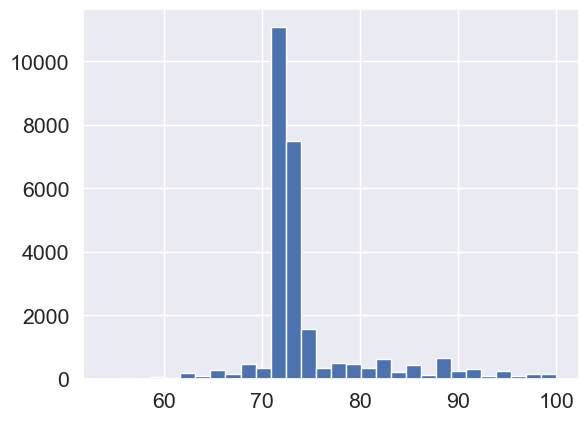

In [276]:
plt.hist([len(s) for s in trnas], bins = 30)

In [277]:
min(len(s) for s in trnas)

54

In [278]:
avg = math.ceil(statistics.mean(len(s) for s in trnas)) #find the average length of sequences

In [279]:
avg

75

In [280]:
for i,s in enumerate(trnas):  #either pad or cut from the sequence so they are the same length 
    if len(s) < avg:
        pad = avg- len(s)
        s += 'N' * pad
        trnas[i] = s
    elif len(s) > avg:
        s = s[:avg]
        trnas[i] = s

In [281]:
N = torch.zeros((avg, 5),  dtype = torch.int32) #create a 5 by sequence length torch matrix

In [282]:
bases = ['A','T','C','G','N']

In [283]:
stoi = {'A': 0, 'T': 1, 'C':2, 'G':3, 'N':4}
itos = {i:s for s,i in stoi.items()}

In [284]:
for seq in trnas: ##get the nucleotide count for each position
    for i, b in enumerate(seq):
        ix2 = i # the row number
        ix1 = stoi[b]
        N[ix2][ix1] += 1

In [285]:
N = N+1 # element wise addition (so we dont have any 0 frequency)

In [286]:
len(trnas)

26726

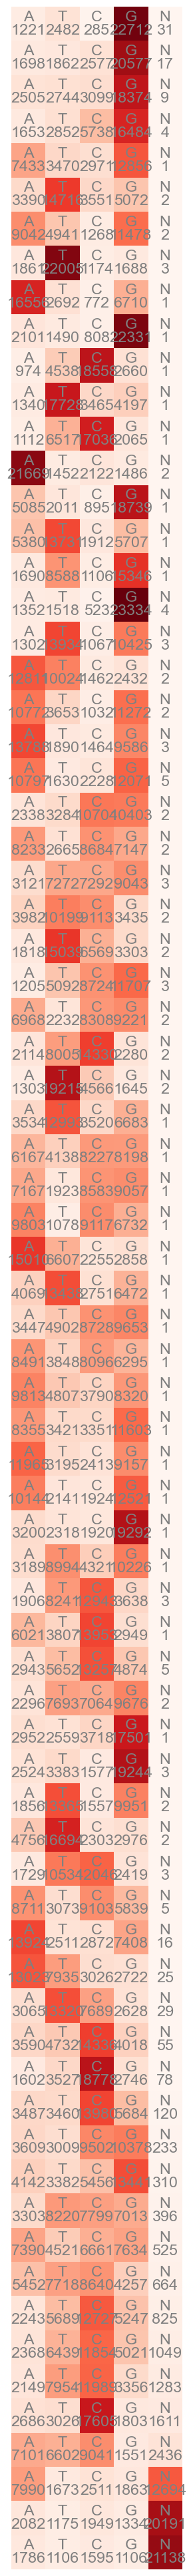

In [287]:
plt.figure(figsize = (50,50))
plt.imshow(N, cmap = 'Reds')
for i in range(5):
    for j in range(avg):
        plt.text(i, j, itos[i], ha = 'center', va = 'bottom', color = 'gray') #horizontal and vertical alognments
        plt.text(i, j, N[j, i].item(), ha = 'center', va = 'top', color = 'gray') # the count at the bottom
plt.axis('off');



In [288]:
P = N.float() #Get the probabilities
P /= P.sum(1, keepdims = True) 

In [289]:
N[0].sum()

tensor(26731)

In [290]:
P.shape

torch.Size([75, 5])

In [291]:
# plt.figure(figsize = (50,50))
# plt.imshow(P, cmap = 'Blues')
# for i in range(5):
#     for j in range(avg):
#         plt.text(i, j, itos[i], ha = 'center', va = 'bottom', color = 'gray') #horizontal and vertical alognments
#         plt.text(i, j, round(P[j, i].item(),2), ha = 'center', va = 'top', color = 'gray') # the count at the bottom
# plt.axis('off');

# Training the model

In [292]:
def seq_probs(sequences):
    probs = []
    for seq in sequences:
        m = 0.0
        for row, base in enumerate(seq):
            col = stoi[base]
            m += torch.log(P[row][col])
        num_events = len(seq)
        probs.append(m/num_events)
    return probs
#https://cs.stackexchange.com/questions/77135/why-is-adding-log-probabilities-faster-than-multiplying-probabilities

In [293]:
trna_probs = seq_probs(trnas)

In [294]:
trna_probs_list = torch.stack(trna_probs).numpy()
sum = reduce(lambda x, y: x + y, trna_probs_list)

In [295]:
sum

-29950.652

In [296]:
trna_average = sum/len(trna_probs) #the mean probability

In [297]:
min(trna_probs_list), max(trna_probs_list)

(-2.8752012, -0.73897475)

In [298]:
test = []

for s, p in zip(trnas, trna_probs_list):
    test.append((s, p))

In [299]:
# test = (sorted(test))
# print(test[:100])

(array([1.000e+00, 2.000e+00, 5.000e+00, 6.000e+00, 1.200e+01, 2.700e+01,
        1.360e+02, 1.296e+03, 2.138e+03, 1.390e+03, 2.431e+03, 2.065e+03,
        3.122e+03, 6.205e+03, 7.890e+03]),
 array([-2.87520123, -2.73278618, -2.59037113, -2.44795585, -2.3055408 ,
        -2.16312575, -2.02071071, -1.87829554, -1.73588049, -1.59346533,
        -1.45105028, -1.30863512, -1.16622007, -1.0238049 , -0.88138986,
        -0.73897475]),
 <BarContainer object of 15 artists>)

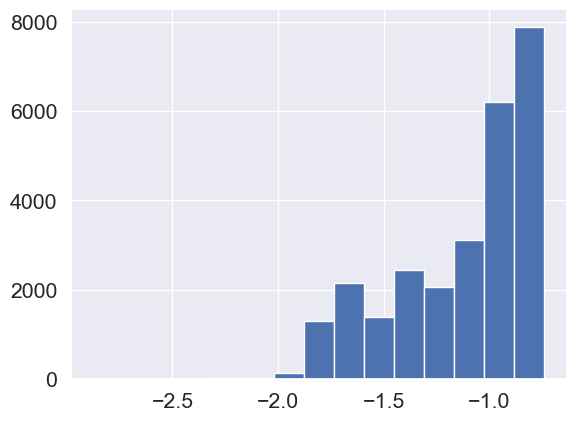

In [300]:
plt.hist(trna_probs_list, bins = 15)

# Testing the model

## Create yes and no tRNA datasets

In [301]:
threshold = min(trna_probs_list)

testing_yes = trnas[-200:]

In [302]:
threshold

-2.8752012

In [303]:
testing_no = []
for _ in range(200):
    np_values = np.asarray(['A', 'T', 'C', 'G'])
    np_count = np.asarray([1, 1, 1, 1])
    np_urn = np.repeat(np_values, np_count)
    N = avg
    sequence = np.random.choice(np_urn, size=N, p=None, replace=True)
    sequence = ''.join(sequence)
    testing_no.append(sequence)


In [304]:
testing_no

['GTGGCGGCCCTATTCCGTGGATTAGAGACCCAGCTATGACCCGTAGATGTGCGGCTGATCTGTTATAGACGACAT',
 'GCAACTAGGACGTTGGACGTGGTTTTAAGCGGGCTATAGCGTCACGCAGTGAATTAGTATAATGTTCCTCGGGTT',
 'TCGGTAAAACTCCGTCTAATATCTATCGATGCTATCATTCAATACCCCAAGATCGTGTTGATCGTAGAGAGCCGT',
 'AAAACTTTGCTCCCAGGATCCTTGTAACCCAGCACAACACTCTCCCTTAGAGTATCTTACCCTGGCATGCCCTTT',
 'ACCTTCCTCGGCCTCAGTGCCGTGTGTGCGTAGCTTCGCACCACGTGTTGGAGGCATGGCCGACCGCTTACGCTG',
 'GAGATTTCCCCCTCGAGTCGAACCACCGAGCCCACACATTCATCCGTTTTTAGGGCTGTCACTAGACCCTTTTGG',
 'CATGGGGCGGACGCTCATCGTATCCGGTAGCGGGCGCGAAGGTAAAGCCGCGCCCAACCATGCAGCAGAGGAATA',
 'TAACAACCGTCTTTAGGAGCAAAGGGAGAGGCCCTTGTCACAGCTTGTGCACCCCCCCGTAGTCTATATCAGCAA',
 'AGTGTCACGTTCCTCGATCTGATGTTTTATTAGAGGACCCCCGGCACATGGGTAGGGGTCTGGGAAGTTGTGCTA',
 'CCATCCCAGTGTGACCTGTCCGGGCTTAAACGATGCTCGTACATAAAGTCACATACGGCCTCGTGAGAGTCACAT',
 'GACTCAAAAATCCTCCCTACAGTGCGTCGCTTCATCAGTCTGCCCTATTAGGCGTCTCTTGCTGCCGGGCAAGGC',
 'CGTCGTTCCGTATCGTCCAACCCGGCCAGTCCGCCTAAGAGACGCTTCTGGGAGTCACGATAGCCTTCTTTCTTT',
 'AATGCACCCTAGGAGGTTAGTTTATAGAATCGGACGCG

In [305]:
res_n = seq_probs(testing_no)

In [306]:
res_y = seq_probs(testing_yes)

In [307]:
min(res_y), max(res_y) #the yes data

(tensor(-1.8240), tensor(-0.7393))

In [308]:
t = torch.stack(res_y).numpy()
sum = reduce(lambda x, y: x + y, t)

In [309]:
sum/len(res_y)

-1.1119475555419922

In [310]:
min(res_n), max(res_n) # the no data 

(tensor(-1.9539), tensor(-1.4972))

In [311]:
t = torch.stack(res_n).numpy()
sum = reduce(lambda x, y: x + y, t)

In [312]:
sum/len(res_n)

-1.7526972961425782

# Stats

In [317]:
rates = {'TN': 0, 'TP' : 0, 'FN': 0, 'FP':0}

for y, n in zip(res_y, res_n):
    if y.item() >= threshold:
        rates['TP'] += 1
    if n.item() >= threshold:
        rates['FP'] += 1
    if y.item() < threshold:
        rates['FN'] += 1
    if n.item() < threshold:
        rates['TN'] += 1


In [314]:
rates

{'TN': 0, 'TP': 200, 'FN': 0, 'FP': 200}

In [315]:
array = [[rates['TN'], rates['FP']], [rates['FN'], rates['TP']]]

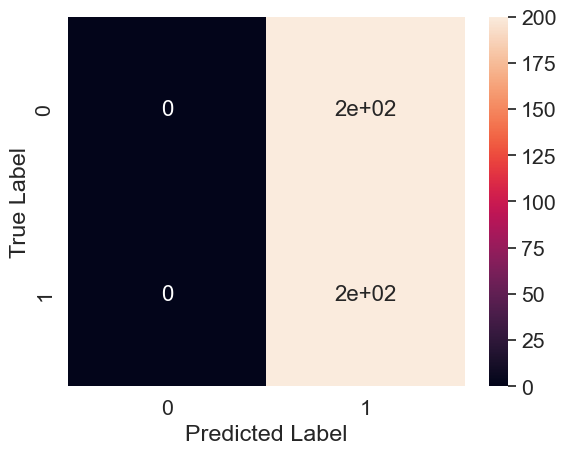

In [316]:
df_cm = pd.DataFrame(array, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()